# Brain WML classification using Deep Learning

Nesta atividade, o objetivo, mais uma vez, é classificar imagens de ressonância magnética com lesões em imagens de lesões isquêmicas (*AVC*) e imagens com lesões desmielinizantes (*EM*). Vamos continuar usando as imagens fornecidas como fatias (imagens 2D).

Em contraste com a atividade da semana passada, usaremos uma rede neural convolucional (CNN) para a classificação. Ou seja, diferentemente do *pipeline* de classificação tradicional, os atributos serão extraídos pela própria CNN e não teremos que nos preocupar com isso.

Este notebook mostra como se faz para carregar as imagens, descrever a CNN a ser usada, treinar e predizer. O treinamento mostrado não trata os dados antes de inseri-los na rede nem utiliza as técnicas mais avançadas de Deep Learning, como *data augmentation* e *transfer learning*. A ideia é que você explore estes passos adicionais, tentando melhorar a acurácia de classificação.


In [ ]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import time
import os
import copy
from sklearn.metrics import confusion_matrix
import glob, os

plt.ion()   # interactive mode

# connect drive
from google.colab import drive
drive.mount('/content/gdrive')

!ls 'gdrive/MyDrive/2022.1_datasci4health/Data_P4_DL/'

Mounted at /content/gdrive
ls: cannot access 'gdrive/MyDrive/2022.1_datasci4health/Data_P4_DL/': No such file or directory


## TODO:
- [ ] Separar aleatoriamente o /Train em test e val, no esquema da professora
  * Tudo é separado em AVC e EM
- [ ] Rodar isso e ver o que acontece
- [ ] Aplicar alguma transformação (flip aleatorio e talvez algum realce? queria fazer o entortar, mas acho que vai gastar muito tempo que eu não tenho.

## **Parte 1 - Carregando os dados (imagens e rótulos) usando o DataLoader**

Normalmente treinamento de CNNs pressupõe o uso de conjuntos de dados muito grandes. O carregamento destes conjuntos de dados em um NB pode dar bastante trabalho e causar problemas, como falta de memória, dentre outros. Para isso, costumamos usar um *dataloader*, especificamente desenvolvido para isso. Para mais informações sobre *dataloader* consulte o [link](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

**Pre-processamento dos dados e Data Augmentation**

As tranformações que queremos fazer nos dados precisam ser definidas antes de chamar o DataLoader. Assim, quando ele carrega os dados, já aplica as transformações desejadas. Você verá que a única transformação que está sendo feita é um redimensionamento das imagens (transform.Resize). Isso é feito pois a CNN só consegue lidar com imagens de treinamento do mesmo tamanho. As outras linhas comentadas da parte do código que faz as transformações dos dados podem ser usadas e modificadas, como forma de fazer um aumento de dados e assim, ajudar no treino. Consulte a documentação sobre *transforms* do Pytorch: https://pytorch.org/vision/stable/transforms.html.

**ATENÇÃO**
Se você escolheu aplicar alguma transformação (por ex: *resize*, *normalize*)com o intuito de pre-processamentos, você deve aplicá-la a todos os conjuntos (**train, val, test**). Porém, se você escolheu uma transformação (por ex: *RandomHorizontalFlip*) como forma de aumento de dados, ela deve ser aplicada somente ao conjunto de treinamento (**train**) e, de preferência, de forma aleatória.

In [ ]:
## Por os conjuntos no lugar certo?
## Ideia: Estou pegando os arquivos do Train da P3 (com lesões isquêmicas e desmielinizantes)
## e separando aleatoriamente entre teste, train e val, no mesmo esquema do subconjunto dado pela prof.

## Clean up, in case I messed up
!rm -rf 'gdrive/MyDrive/P4/'
!cp -r 'gdrive/MyDrive/Train/' 'gdrive/MyDrive/P4/'
# Smooth operator
!mkdir 'gdrive/MyDrive/P4/train'

!mv 'gdrive/MyDrive/P4/AVC' 'gdrive/MyDrive/P4/train/AVC'
!mv 'gdrive/MyDrive/P4/EM' 'gdrive/MyDrive/P4/train/EM'

for f in glob.glob("gdrive/MyDrive/P4/train/EM/*_mask*"):
    os.remove(f)

for f in glob.glob("gdrive/MyDrive/P4/train/AVC/*_mask*"):
    os.remove(f)

#!set +f
#!rm "gdrive/MyDrive/P4/train/AVC"/*"_mask.bmp"

!ls 'gdrive/MyDrive/P4/'

!mkdir -p 'gdrive/MyDrive/P4/test/AVC'
!mkdir -p 'gdrive/MyDrive/P4/test/EM'

!mkdir -p 'gdrive/MyDrive/P4/val/AVC'
!mkdir -p 'gdrive/MyDrive/P4/val/EM'

!ls 'gdrive/MyDrive/P4/train/AVC' | wc -l
## 2056 files, 1475 after mask removal
## 20% de 2056: 294
## 10% de 2056: 147

!ls 'gdrive/MyDrive/P4/train/AVC' | shuf -n 294 | xargs -i mv 'gdrive/MyDrive/P4/train/AVC/'{} 'gdrive/MyDrive/P4/test/AVC'
!ls 'gdrive/MyDrive/P4/train/AVC' | shuf -n 147 | xargs -i mv 'gdrive/MyDrive/P4/train/AVC/'{} 'gdrive/MyDrive/P4/val/AVC'

!ls 'gdrive/MyDrive/P4/test/AVC' | wc -l
!ls 'gdrive/MyDrive/P4/val/AVC' | wc -l

!ls 'gdrive/MyDrive/P4/train/EM' | wc -l
## 2974 files, 2344 after
## 20% de 2947: 588 468
## 10% de 2947: 294 234

!ls 'gdrive/MyDrive/P4/train/EM' | shuf -n 468 | xargs -i mv 'gdrive/MyDrive/P4/train/EM/'{} 'gdrive/MyDrive/P4/test/EM'
!ls 'gdrive/MyDrive/P4/train/EM' | shuf -n 234 | xargs -i mv 'gdrive/MyDrive/P4/train/EM/'{} 'gdrive/MyDrive/P4/val/EM'

!ls 'gdrive/MyDrive/P4/test/EM' | wc -l
!ls 'gdrive/MyDrive/P4/val/EM' | wc -l

cp: cannot stat 'gdrive/MyDrive/Train/': No such file or directory
mkdir: cannot create directory ‘gdrive/MyDrive/P4/train’: No such file or directory
mv: cannot stat 'gdrive/MyDrive/P4/AVC': No such file or directory
mv: cannot stat 'gdrive/MyDrive/P4/EM': No such file or directory


NameError: ignored

In [ ]:
'''
#!rm -rf 'gdrive/MyDrive/P4/SLE'
# nao funciona, nao rodar.
!cp -r --no-preserve=mode,ownership 'gdrive/MyDrive/SLE' 'gdrive/MyDrive/P4/'
!ls 'gdrive/MyDrive/P4/'
!ls 'gdrive/MyDrive/P4/SLE' | wc -l

for f in glob.glob("gdrive/MyDrive/P4/SLE/*_mask.png"):
    print(f)
    os.remove(f)
'''

'\n#!rm -rf \'gdrive/MyDrive/P4/SLE\'\n# nao funciona, nao rodar.\n!cp -r --no-preserve=mode,ownership \'gdrive/MyDrive/SLE\' \'gdrive/MyDrive/P4/\'\n!ls \'gdrive/MyDrive/P4/\'\n!ls \'gdrive/MyDrive/P4/SLE\' | wc -l\n\nfor f in glob.glob("gdrive/MyDrive/P4/SLE/*_mask.png"):\n    print(f)\n    os.remove(f)\n'

In [ ]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(5),
        #transforms.Normalize(0, 1),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(5),
        #transforms.Normalize(0, 1),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]),
    'test': transforms.Compose([
        transforms.Resize((170,170)),
        #transforms.Normalize(0, 1),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]),
}

data_dir = 'gdrive/MyDrive/P4/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

## **Visualizando algumas imagens (one batch)**

Muitas vezes treinamos uam rede neural em *batches*, quer dizer, separamos o conjunto de treino em sub-conjuntos menores. Se temos um conjunto de treino de M amostras, podemos ter M *batches* de tamanho 1 amostra até 1 *batch* de M amostras.

Batch of training data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


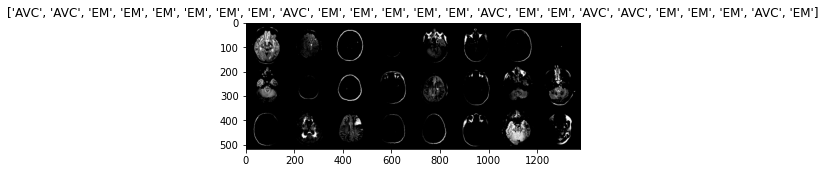

min =  -1.0
median =  -1.0
mean =  -0.70128965
max =  0.99215686
Batch of validation data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


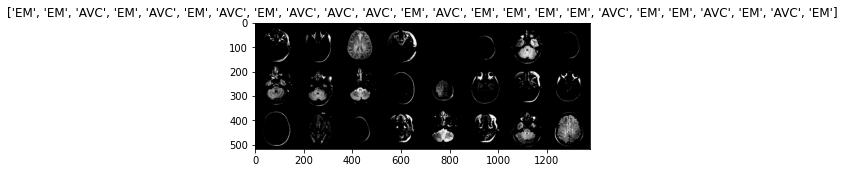

min =  -1.0
median =  -1.0
mean =  -0.69006103
max =  0.99215686
Batch of test data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


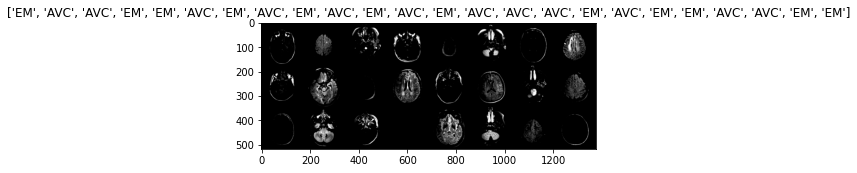

min =  -1.0
median =  -1.0
mean =  -0.67627174
max =  0.99215686


In [ ]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))


print('Batch of validation data')
inputs, classes = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

print('Batch of test data')
inputs, classes = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

# Training

Defining trainer

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    torch.save(model.state_dict(), 'gdrive/MyDrive/P4/model.model')
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'gdrive/MyDrive/P4/model.model')
                
            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc)
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc)
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


Define training parameters. The chosen architecture is a ResNet18 and it can be used pretrained or not.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2 (number of classes).
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device) #send the model to GPU if it is available or CPU otherwise

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.0008, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.000005, momentum=0.9)

# Decay LR by a factor of "gamma" every "step_size" epochs
# https://pytorch.org/docs/stable/optim.html
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# print(model) # show CNN architecture

summary(model, (3, 170, 170)) # summarize the model 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 85, 85]           9,408
       BatchNorm2d-2           [-1, 64, 85, 85]             128
              ReLU-3           [-1, 64, 85, 85]               0
         MaxPool2d-4           [-1, 64, 43, 43]               0
            Conv2d-5           [-1, 64, 43, 43]          36,864
       BatchNorm2d-6           [-1, 64, 43, 43]             128
              ReLU-7           [-1, 64, 43, 43]               0
            Conv2d-8           [-1, 64, 43, 43]          36,864
       BatchNorm2d-9           [-1, 64, 43, 43]             128
             ReLU-10           [-1, 64, 43, 43]               0
       BasicBlock-11           [-1, 64, 43, 43]               0
           Conv2d-12           [-1, 64, 43, 43]          36,864
      BatchNorm2d-13           [-1, 64, 43, 43]             128
             ReLU-14           [-1, 64,

Start training

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

# model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
#                        num_epochs=200)
model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5126 Acc: 0.7601
val Loss: 0.3869 Acc: 0.8478

Epoch 1/9
----------
train Loss: 0.3383 Acc: 0.8711
val Loss: 0.3007 Acc: 0.8740

Epoch 2/9
----------
train Loss: 0.2822 Acc: 0.8976
val Loss: 0.2545 Acc: 0.9055

Epoch 3/9
----------
train Loss: 0.2525 Acc: 0.9107
val Loss: 0.2343 Acc: 0.8871

Epoch 4/9
----------
train Loss: 0.2356 Acc: 0.9084
val Loss: 0.2229 Acc: 0.8950

Epoch 5/9
----------


Show training

Visualizing the model predictions for test group

In [ ]:
def predic_model(model, plot_img = False, num_images=24):
    was_training = model.training
    model.eval()
    images_so_far = 0
    PREDICTED = []
    LABEL = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
              images_so_far += 1
              PREDICTED.append(class_names[preds[j]])
              LABEL.append(class_names[labels[j]])
              if plot_img:
                plt.figure()
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                plt.axis('off')
                plt.title('predicted: {} - label: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                plt.plot()

              if images_so_far == num_images:
                model.train(mode=was_training)
                # break
                return PREDICTED, LABEL

        model.train(mode=was_training)

    return PREDICTED, LABEL

In [ ]:
test_group_len = 468
PREDICTED, LABEL = predic_model(model, plot_img = False, num_images=test_group_len)
#model = model.load_state_dict(torch.load('gdrive/MyDrive/P4/model.model'))

In [ ]:
test_AVC_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'AVC'])
test_EM_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'EM'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_EM_size # Sensibilidade: é a razão entre as imagens com EM classificadas corretamente e o total de imagens com EM (Verdadeiros positivos ÷ EM)
Especificidade = CM_test[0,0]/test_AVC_size # Especificidade: é a razão entre as imagens com AVC classificadas corretamente e o total de imagens com AVC (Verdadeiros negativos ÷ AVC)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)



In [ ]:
# rodar validacao e SCM pra decidir as coisas
# decisoes ate agora: testado resnet101 e 50, melhor vai ser 50 (nao foi) 18 pre treinada?
# para aumentar os dados, horizontal flip (para simular diferentes lugares de lesao) e 
# angulacao aleatoria de 5 graus, para simular posicoes erradas da cabeça

In [ ]:
from torch.autograd import Variable

transformed_img = transforms.Compose([
                    transforms.Resize((170,170)),
                    #transforms.Normalize(0, 1),
                    transforms.ToTensor(),
                    transforms.Normalize(0.5, 0.5),
                    ])
'''  
def predict_image(image):
  image_tensor = sle_transforms(image).float()
  image_tensor = image_tensor.unsqueeze_(0)
  input = Variable(image_tensor)
  input = input.to(device)
  output = model(input)
  index = output.data.cpu().numpy().argmax()
  return index
'''
def predic_sle(model, plot_img = False, num_images=24):
    #print(model)
    was_training = model.training
    model.eval()
    images_so_far = 0
    PREDICTED = []
    LABEL = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(datal_sle):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
              images_so_far += 1
              PREDICTED.append(class_names[preds[j]])
              LABEL.append(class_names[labels[j]])
              if plot_img:
                plt.figure()
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                plt.axis('off')
                plt.title('predicted: {} - label: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                plt.plot()

              if images_so_far == num_images:
                model.train(mode=was_training)
                # break
                return PREDICTED, LABEL

        model.train(mode=was_training)

    return PREDICTED, LABEL
#model = torch.load(model.state_dict(), 'gdrive/MyDrive/P4/model.model')

#!cp -r 'gdrive/MyDrive/P4/SLE' 'gdrive/MyDrive/P4/SLE/sle'  
sle_imgs = datasets.ImageFolder(os.path.join('gdrive/MyDrive/P4', 'SLE'), transformed_img)
print(sle_imgs)
datal_sle = torch.utils.data.DataLoader(sle_imgs, batch_size=24, shuffle=True, num_workers=2)

predic_sle(model)
#for image in :
#  index = predict_image(image)
 # print (index)

#prediction = class_map[str(index)][1]

#print("Predicted Class ", prediction)
